In [1]:
import numpy as np
from lib import plot
import IPython
import cv2
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator
from copy import deepcopy

# Defaults
TEXT_TOP = None
TEXT_BOTTOM = None
TEXT_TOP_FIT = False
TEXT_BOTTOM_FIT = False
TEXT_TOP_SPACE = 0
TEXT_BOTTOM_SPACE = 0

INVERT = True               # Set to true when plotting with a white pen
HATCH_ANGLE = 10
ANGLE_FLIP = False          # Mirror hatch lines for darker areas
ANGLE_ROTATE = True         # Cross-hatch by rotating by 90 degrees
PAPER = plot.A6_PORTRAIT

FILENAME = 'data/frida.jpg'
NAME = 'frida'

# FILENAME = 'data/boltzmann.jpg'
# NAME = 'boltzmann'
# TEXT_BOTTOM = 'BOLTZMANN'
# TEXT_BOTTOM_FIT = True

PAPER.set_margins(10)
if TEXT_TOP is not None:
    PAPER.margins['top'] += 10
if TEXT_BOTTOM is not None:
    PAPER.margins['bottom'] += 10

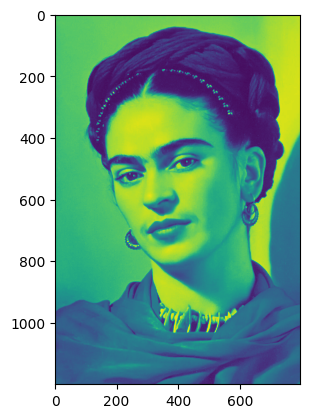

In [2]:
img = cv2.imread(FILENAME, cv2.IMREAD_UNCHANGED)

if img.shape[-1] == 4:
    # Image has an alpha channel
    if INVERT:
        img = img[:, :, :3]
    else:
        img = 255 - (255 - img[:, :, :3]) * img[:, :, [3]] / 255

img = img.dot([0.07, 0.72, 0.21]) / 255

paper_aspect = PAPER.content_width / PAPER.content_height
img_aspect = img.shape[1] / img.shape[0]
if img_aspect < paper_aspect:
    new_height = round(img.shape[1] / paper_aspect)
    y_offset = (img.shape[0] - new_height) // 2
    img = img[y_offset:y_offset + new_height, :]
else:
    new_width = round(img.shape[0] * paper_aspect)
    x_offset = (img.shape[1] - new_width) // 2
    img = img[:, x_offset:new_width + x_offset]

img = img - np.min(img)
img = img / np.max(img)
if not INVERT:
    img = 1 - img

plt.imshow(img[:, :])

xs = np.linspace(PAPER.left(), PAPER.right(), img.shape[1])
ys = np.linspace(PAPER.top(), PAPER.bottom(), img.shape[0])
img_interp = RegularGridInterpolator((xs, ys), img.T, bounds_error=False, fill_value=0)

(array([104098.,  76074.,  77126., 140403.,  64943.,  50219., 132457.,
        151751., 109284.,  50045.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

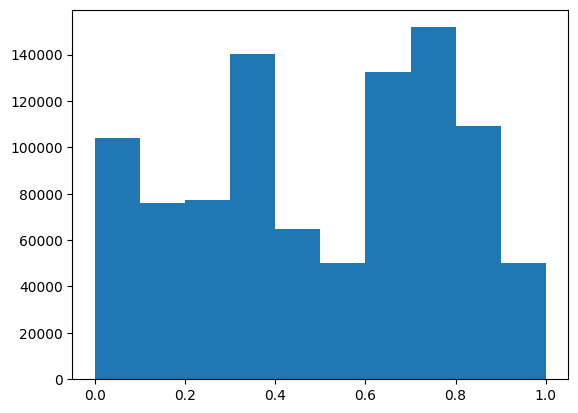

In [3]:
plt.hist(img.ravel())

Thresholds: [0.02960397 0.39052043 0.65223211 0.81757342 0.87103378]


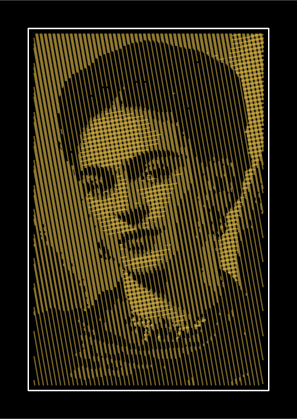

In [4]:
paper = deepcopy(PAPER)

pen_colour = [0, 0, 0]
if INVERT:
    paper.background_colour = [0, 0, 0]
    pen_colour = [1, 1, 1]

p_svg = plot.SVGPlotter(f'plots/hatch_{NAME}.svg', paper, colour=pen_colour)
p_hpgl = plot.HPGLPlotter(paper, f'plots/hatch_{NAME}_{{index}}.hpgl')
plotter = plot.MultiPlotter()
plotter.register_plotter(p_svg)
plotter.register_plotter(p_hpgl)

plotter.move_to(paper.bottom_left())
plotter.line_to(paper.bottom_right())
plotter.line_to(paper.top_right())
plotter.line_to(paper.top_left())
plotter.line_to(paper.bottom_left())

if TEXT_TOP:
    plotter.draw_text(TEXT_TOP, (paper.centre()[0], paper.top() - 5), x_scale=0.75, spacing=TEXT_TOP_SPACE, fit_width=paper.content_width if TEXT_TOP_FIT else None, h_align='centre', v_align='bottom')
if TEXT_BOTTOM:
    plotter.draw_text(TEXT_BOTTOM, (paper.centre()[0], paper.bottom() + 5), x_scale=0.75, spacing=TEXT_BOTTOM_SPACE, fit_width=paper.content_width if TEXT_BOTTOM_FIT else None, h_align='centre', v_align='top')

for k in paper.margins.keys():
    paper.margins[k] += 2

if INVERT:
    plotter.add_layer([0.9, 0.75, 0.3, 0.5])
else:
    plotter.add_layer([0.3, 0.25, 0, 0.5])

def filter_points(points):
    return points[
        np.logical_and(
            np.logical_and(
                paper.left() <= points[:, 0],
                points[:, 0] <= paper.right(),
            ),
            np.logical_and(
                paper.top() <= points[:, 1],
                points[:, 1] <= paper.bottom()
            )
        )
    ]

def x_line_points(start_x, angle, count):
    points = np.linspace([start_x, paper.top()], [start_x + np.tan(angle / 360 * 2 * np.pi) * paper.content_height, paper.bottom()], count)
    return filter_points(points)

def y_line_points(start_y, angle, count):
    points = np.linspace([paper.left(), start_y], [paper.right(), start_y + np.tan((90 - angle) / 360 * 2 * np.pi) * paper.content_width], count)
    return filter_points(points)

def hatch(phase, threshold, angle=45, resolution=1, distance=2, noise=0, reverse_order=False):
    while angle > 180:
        angle -= 180
    while angle < 0:
        angle += 180

    if 45 < angle < 135:
        # Shallow lines
        points = int(paper.content_height / np.sin(angle / 360 * 2 * np.pi) / resolution)
        line_starts = np.arange(-paper.top() - paper.content_width - phase * distance, paper.bottom() + paper.content_width, distance / np.sin(angle / 360 * 2 * np.pi))
        lines = [y_line_points(start, angle, points) for start in line_starts]
    else:
        # Steep lines
        points = abs(int(paper.content_height / np.cos(angle / 360 * 2 * np.pi) / resolution))
        line_starts = np.arange(-paper.left() - paper.content_height - phase * distance, paper.right() + paper.content_height, abs(distance / np.cos(angle / 360 * 2 * np.pi)))
        lines = [x_line_points(start, angle, points) for start in line_starts]

    if reverse_order:
        lines = lines[::-1]

    for (i, line) in enumerate(lines):
        if line.size == 0:
            continue

        if noise:
            line += np.random.normal(scale=noise, size=line.shape)

        # Mirror every second line for quicker plotting
        if i % 2 == 0:
            line = line[::-1, :]

        values = img_interp(line)  # swap x and y
        pen_down = False
        for v, p in zip(values, line):
            if v > threshold:
                if not pen_down:
                    plotter.move_to(p)
                else:
                    plotter.line_to(p)

                pen_down = True
            else:
                pen_down = False
            
            last_point = p

thresholds = np.quantile(img[img > 0.001].ravel(), [0.001, 0.4, 0.6, 0.85, 0.9])
print('Thresholds:', thresholds)
phases = np.linspace(0, 1, len(thresholds), endpoint=False)

for i in range(len(thresholds)):
    angle = 10
    if i > len(thresholds) / 2:
        if ANGLE_FLIP:
            angle *= -1
        if ANGLE_ROTATE:
            angle += 90
    hatch(phases[i], thresholds[i], angle, distance=1.5, resolution=0.5, reverse_order=i % 2, noise=0.0)

plotter.finalise()
IPython.display.SVG(filename=p_svg.file_name)